In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import trimesh

In [3]:
df = pd.read_pickle('./data.pkl')

In [15]:
# TPC boundaries (cm)
tpcMinX = -200
tpcMaxX = 200
tpcMinY = -200
tpcMaxY = 200
tpcMinZ = 0
tpcMaxZ = 500

# Beam center (cm)
beamCenterX = -74
beamCenterY = 0
beamCenterZ = 11000

In [4]:
# Plot settings
colorTot = 'C0'; colorP = 'C1'; colorNP = 'C2'
ylimit = (0,)
xlimit=(0,)
erAlpha = 0.3

nbins = np.arange(0, 4.1, .2)
nbinsTPC = np.arange(0, 1.61, .2)

In [16]:
# Front face normalization
norm_areas = np.array([])
r1 = 1.26  # m
r2 = 2.0   # m
r3 = 2.74  # m
for i in range(len(nbinsTPC)-1):
    radius = (beamCenterZ/100) * np.tan(nbinsTPC[i+1] * np.pi / 180)
    area = np.pi * radius**2
    if i > 0:
        if radius > r1:
            area -= quad(lambda x: 2*np.sqrt(radius**2 - x**2), 1.26, radius)[0]
        if radius > r2:
            area -= quad(lambda y: 4*np.sqrt(radius**2 - y**2), 2, radius)[0]
        if radius > np.sqrt(r1**2 + r2**2):
            area += quad(lambda x1: 2*(np.sqrt(radius**2 - x1**2) - 2), 1.26, np.sqrt(radius**2 - 4))[0]
        if radius > r3:
            area -= quad(lambda z: 2*np.sqrt(radius**2 - z**2), 2.74, radius)[0]
        if radius > np.sqrt(r3**2 + r2**2):
            area += quad(lambda x2: 2*(np.sqrt(radius**2 - x2**2) - 2), 2.74, np.sqrt(radius**2 - 4))[0]
        area -= np.sum(norm_areas[0:i])
    if area < 1e-5:
        area = 0
    norm_areas = np.append(norm_areas, np.abs(area))
norm_areas

array([0.46318395, 1.38959699, 2.31614549, 2.91337013, 3.17304591,
       2.64577569, 1.79511938, 1.07684058])

In [17]:
# Back face normalization
norm_areas_back = np.array([])
for i in range(len(nbinsTPC)-1):
    radius = ((beamCenterZ+tpcMaxZ-tpcMinZ)/100) * np.tan(nbinsTPC[i+1] * np.pi / 180)
    area = np.pi * radius**2
    if i > 0:
        if radius > r1:
            area -= quad(lambda x: 2*np.sqrt(radius**2 - x**2), 1.26, radius)[0]
        if radius > r2:
            area -= quad(lambda y: 4*np.sqrt(radius**2 - y**2), 2, radius)[0]
        if radius > np.sqrt(r1**2 + r2**2):
            area += quad(lambda x1: 2*(np.sqrt(radius**2 - x1**2) - 2), 1.26, np.sqrt(radius**2 - 4))[0]
        if radius > r3:
            area -= quad(lambda z: 2*np.sqrt(radius**2 - z**2), 2.74, radius)[0]
        if radius > np.sqrt(r3**2 + r2**2):
            area += quad(lambda x2: 2*(np.sqrt(radius**2 - x2**2) - 2), 2.74, np.sqrt(radius**2 - 4))[0]
        area -= np.sum(norm_areas[0:i])
    if area < 1e-5:
        area = 0
    norm_areas_back = np.append(norm_areas_back, np.abs(area))
norm_areas_back

array([0.50624857, 1.56185968, 2.70375229, 3.46214343, 3.94690699,
       3.15426951, 2.28352461, 1.23375337])

In [18]:
# exact volume normalization
tpcBox = trimesh.creation.box(extents=[4, 4, 5])
tpcBox.apply_translation([0, 0, 2.5])
norm_vols = np.array([])
for i in range(len(nbinsTPC)-1):
    radius = 115 * np.tan(nbinsTPC[i+1] * np.pi / 180)
    cone = trimesh.creation.cone(radius=radius, height=115)
    vol = cone.volume - cone.difference(tpcBox).volume
    if i > 0:
        vol -= np.sum(norm_vols[0:i])
    if vol < 1e-5:
        vol = 0
    norm_vols = np.append(norm_vols, vol)
norm_vols

array([ 2.40724613,  7.22197472, 12.03740189, 16.85401715, 21.671929  ,
       14.81727631,  4.82415596,  0.16597083])

2571


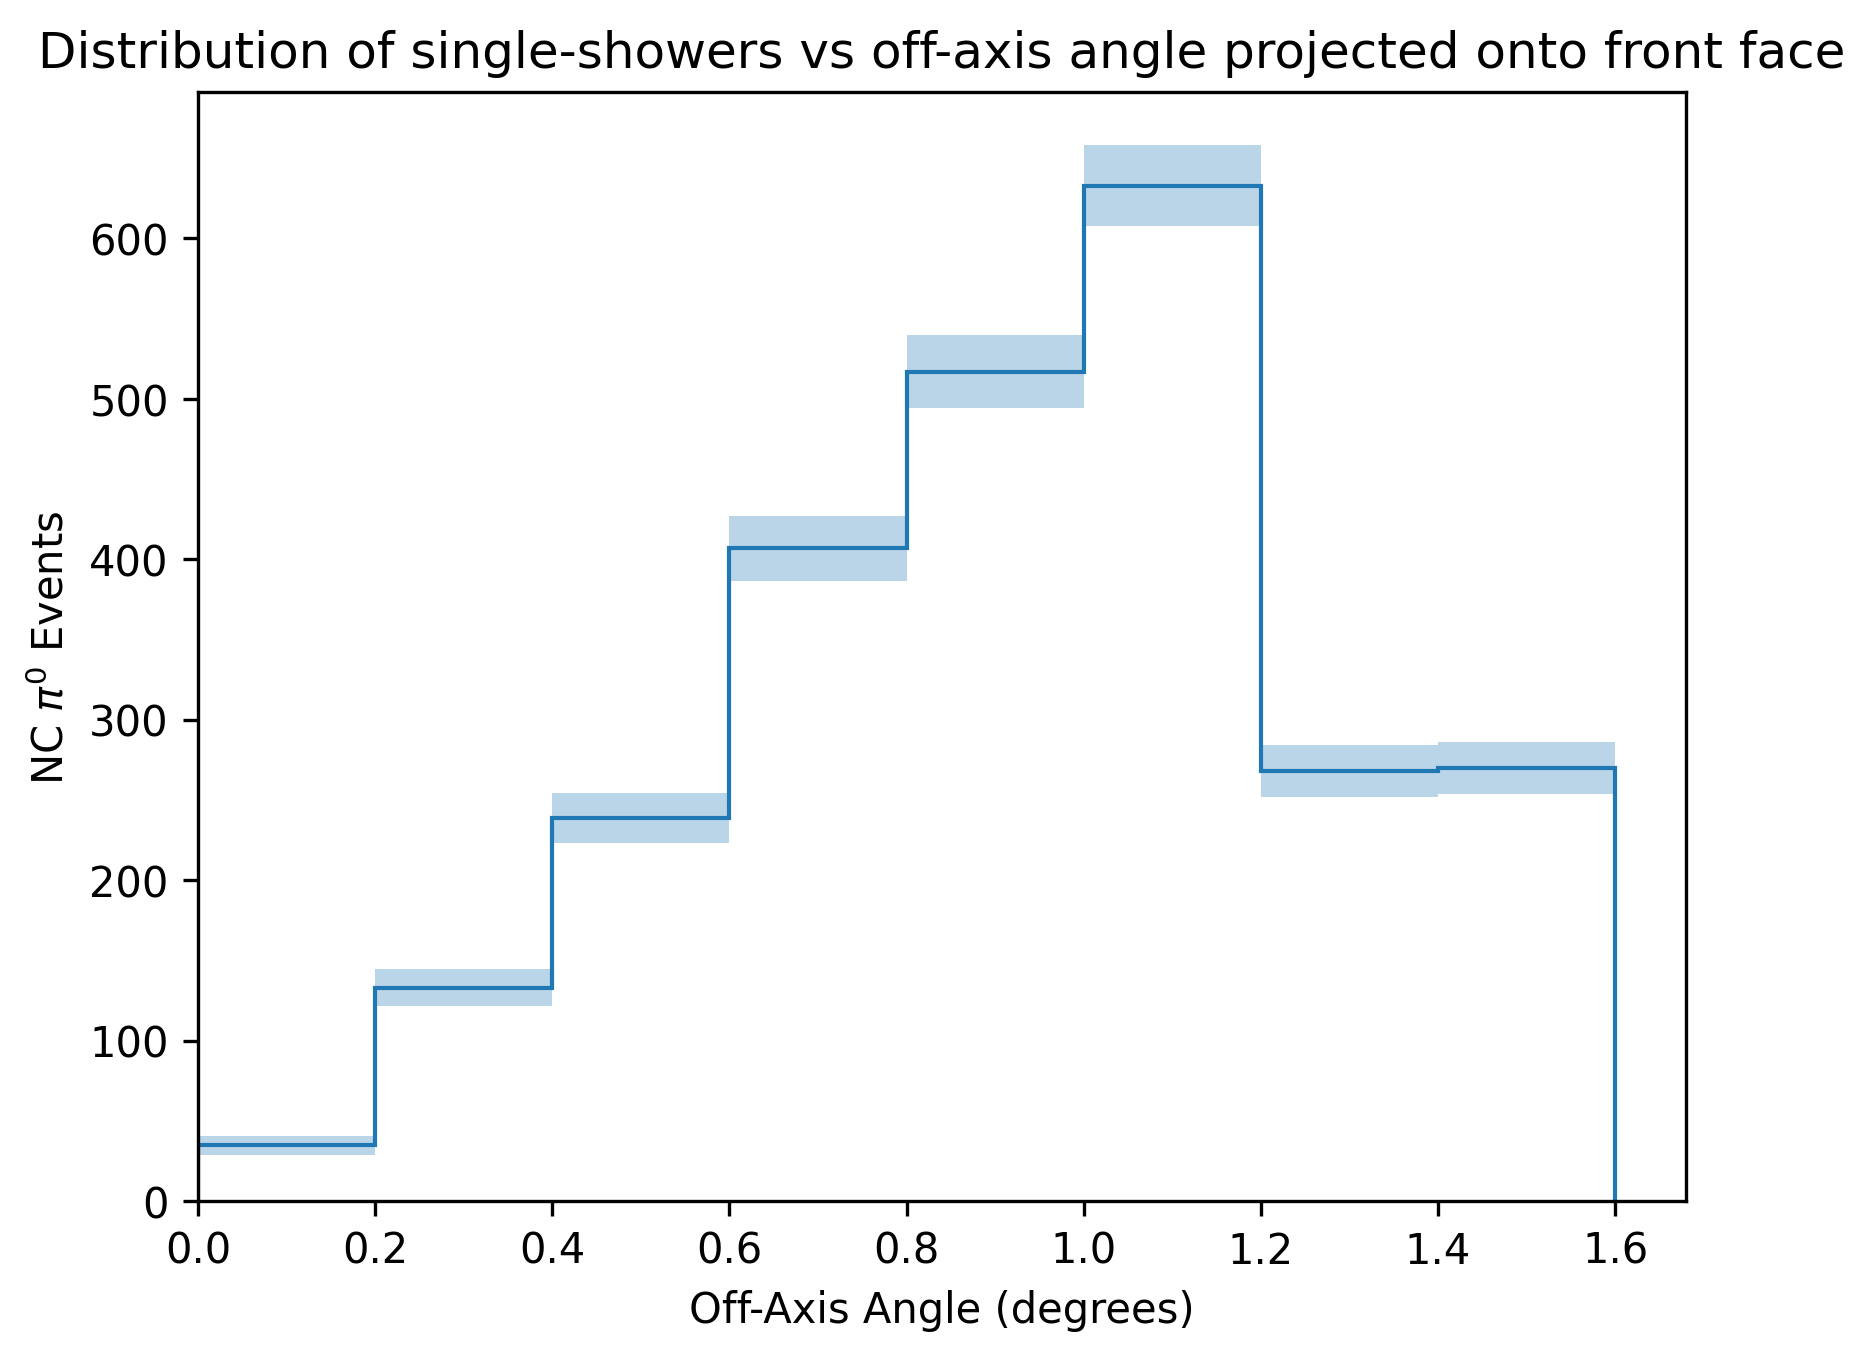

In [19]:
angles_front = np.array([])
for idx, row in df[df['is_NC'] & df['single_shower']].iterrows():
    angles_front = np.append(angles_front, row['shower_angle_front'])
print(len(angles_front))

plt.figure(dpi=300)
counts_front, bins_front, _ = plt.hist(angles_front, bins=nbinsTPC, histtype='step')
wide_front = np.diff(bins_front)
plt.clf()  # clear the previous plot
bin_centers_front = 0.5 * (bins_front[:-1] + bins_front[1:])
errors_front = np.sqrt(counts_front)
plt.bar(bin_centers_front, 2*errors_front, width=wide_front, bottom=counts_front-errors_front, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins_front[:-1], bins=bins_front, weights=counts_front, histtype='step', color=colorTot)
plt.title('Distribution of single-showers vs off-axis angle projected onto front face')
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events')
plt.xlim(*xlimit)
plt.ylim(*ylimit)

plt.show()

2571


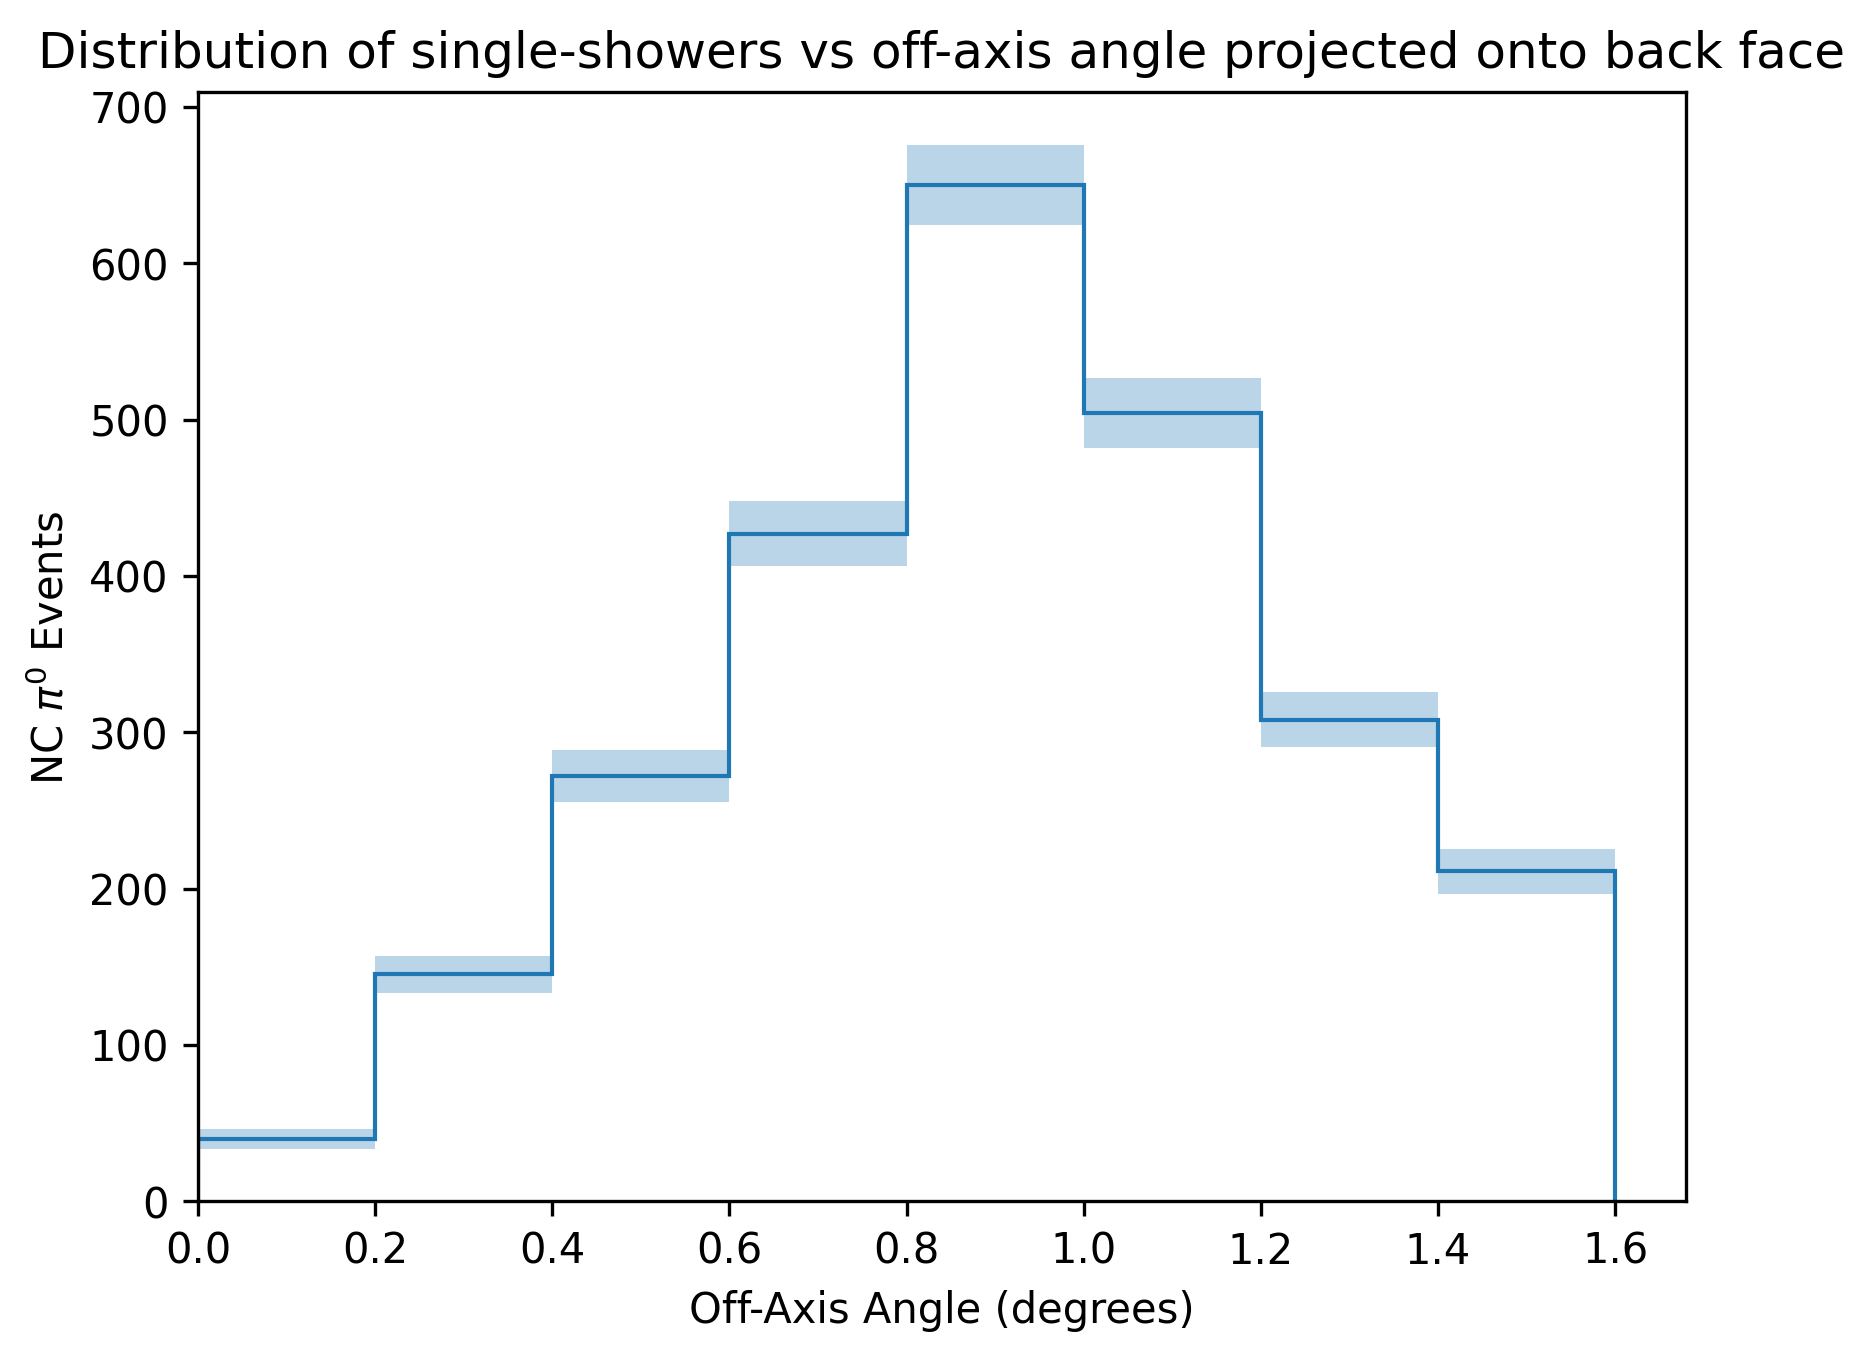

In [20]:
angles_back = np.array([])
for idx_back, row_back in df[df['is_NC'] & df['single_shower']].iterrows():
    angles_back = np.append(angles_back, row_back['shower_angle_back'])
print(len(angles_back))

plt.figure(dpi=300)
counts_back, bins_back, _ = plt.hist(angles_back, bins=nbinsTPC, histtype='step')
wide_back = np.diff(bins_back)
plt.clf()  # clear the previous plot
bin_centers_back = 0.5 * (bins_back[:-1] + bins_back[1:])
errors_back = np.sqrt(counts_back)
plt.bar(bin_centers_back, 2*errors_back, width=wide_back, bottom=counts_back-errors_back, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins_back[:-1], bins=bins_back, weights=counts_back, histtype='step', color=colorTot)
plt.title('Distribution of single-showers vs off-axis angle projected onto back face')
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.show()

In [14]:
for idx, row in df[df['is_NC'] & df['single_shower']].iterrows():
    if row['shower_angle_back'][0] > 1.4:
        print(row['shower_position'])

[(np.float32(146.23491), np.float32(195.96532), np.float32(203.61165))]
[(np.float32(158.78545), np.float32(165.24944), np.float32(144.77138))]
[(np.float32(166.98567), np.float32(149.12923), np.float32(79.11272))]
[(np.float32(179.81967), np.float32(-146.12944), np.float32(425.01535))]
[(np.float32(163.49269), np.float32(197.32101), np.float32(346.48413))]
[(np.float32(140.10013), np.float32(183.62961), np.float32(119.214806))]
[(np.float32(199.29881), np.float32(127.8525), np.float32(194.34108))]
[(np.float32(182.32208), np.float32(189.7507), np.float32(369.55652))]
[(np.float32(167.40804), np.float32(163.7443), np.float32(461.35373))]
[(np.float32(152.06506), np.float32(198.83711), np.float32(462.38452))]
[(np.float32(183.3745), np.float32(176.68271), np.float32(274.95978))]
[(np.float32(186.91446), np.float32(125.09575), np.float32(402.68933))]
[(np.float32(158.72177), np.float32(158.92181), np.float32(7.3228984))]
[(np.float32(188.00667), np.float32(131.33078), np.float32(294.1826